In [1]:
'''
author: Yike Xie
data: 22/2/2023
content: correlate image features and exon transcriptome
'''

'\nauthor: Yike Xie\ndata: 22/2/2023\ncontent: correlate image features and exon transcriptome\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/exon_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
# exclude exons corresponding to unknown genes
adata = adata[:, adata.var['gene_name'] != '']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/exon/version2_95cells/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


filter genes


Trying to set attribute `.var` of view, copying.
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [5]:
# percentage of cells expressing this gene
g_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata_g = sig_dataset(feas_fn, g_fn)

# pct = 0.8
# gene_pct = pd.Series((adata_g.X > 0).sum(axis=0) / adata_g.obs.shape[0], index=adata_g.var_names)
# high_pct = gene_pct[gene_pct >= pct].index

load features
load dataset


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.var` of view, copying.


filter single cells
filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [6]:
# fraction of exons inside the correspond genes
if True: 
    adata_g = adata.copy()
    adata_g.var = adata_g.var.reset_index().set_index('gene_name')

    exon_ls = np.array(adata.var['exon_id'])
    gene_ls = np.array(adata.var['gene_name'])

    # get the datafram contaning gene expression
    gene_unique = np.unique(gene_ls)
    gene_unique_exps = np.empty((adata.X.shape[0], len(gene_unique)), float)
    for i, gene in enumerate(gene_unique):
        gene_unique_exps[:, i] = adata_g[:, gene].X.sum(axis=1)
    gene_unique_exps = pd.DataFrame(gene_unique_exps, index=adata.obs_names, columns=gene_unique)

    # get gene expression
    gene_exps = gene_unique_exps[gene_ls].values

    # get fraction
    exon_exps = adata.X
    exon_fra = exon_exps / (gene_exps + 0.001)
    exon_fra_df = pd.DataFrame(exon_fra, columns=exon_ls, index=adata.obs_names)

    # save fraction
    exon_fra_df.T.to_csv(save_figures + 'exon_fraction.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [7]:
# compute correlations of all exons
if True:    
    print('Correlate with some simple features')
    feas = ['area']
    labels = ['Area [$px^2$]']
    
    adata_e = adata[:, (adata.X > 0).sum(axis=0) > 0]
    phe = adata[:, adata_e.var_names].obs[feas].fillna(0)

    exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)
    x = exon_fra_df.loc[adata_e.var_names].values #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros(y.shape, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_e.var_names,
                    columns=phe.columns,
                    dtype=float)

    corr['gene_name'] = adata.var.loc[corr.index]['gene_name']
    corr['exon_number'] = adata.var.loc[corr.index]['exon_number']

    corr.to_csv(save_figures + 'area_exon_fra_all.tsv', sep='\t')

Correlate with some simple features


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [8]:
# filter genes to find exons with good correlations
if False:
    # filter out exons with 0 expression
    adata_e = adata[:, (adata.X > 0).sum(axis=0) > 0]

    # get dataframe with the expression of exons and number of cells expressing the exon
    exon_n = pd.DataFrame((adata_e.X > 0).sum(axis=0), index=adata_e.var_names, columns=['exon_n'])
    exon_n['exon_exp'] = adata_e.X.sum(axis=0)
    exon_n['gene_name'] = adata_e.var['gene_name']
    
    # filter exons expressed by more than 70 cells
    exon_n = exon_n[exon_n['exon_n'] >=70]

    # filter genes with at least two exons
    ft_g = exon_n.groupby('gene_name').size().sort_values(ascending=False).to_frame()
    ft_g = ft_g[ft_g[0] >=2 ]
    ft_g = ft_g[ft_g.index != '']

    exon_n = exon_n[exon_n['gene_name'].isin(ft_g.index)]

if False:
    print('Correlate with some simple features')
    feas = ['area']
    labels = ['Area [$px^2$]']
    
    phe = adata.obs[feas].fillna(0)

    exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)
    x = exon_fra_df.loc[exon_n.index].values
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros(y.shape, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=exon_n.index,
                    columns=phe.columns,
                    dtype=float)

    corr['gene_name'] = adata.var.loc[corr.index]['gene_name']
    corr['exon_number'] = adata.var.loc[corr.index]['exon_number']

    corr.to_csv(save_figures + 'area_exon_fra.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Correlate with some simple features


In [8]:
if False:
    #######
    corr = pd.read_csv(save_figures + 'area_exon_fra.tsv', sep='\t', index_col=0)
    exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)[adata.obs_names]

    feas = ['area']
    labels = ['Area [px]']

    n_exons = 3
    colors = sns.color_palette('tab10', 2 * n_exons)
    colors = [colors[: n_exons], colors[n_exons:]]

    fig, axs = plt.subplots(2, 1, figsize=(5, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"

    fea = feas[0]
    exons_both = [
            corr.nlargest(n_exons, fea).index.tolist(),
            corr.nsmallest(n_exons, fea).index.tolist(),
        ]
    for j, (ax, exons) in enumerate(zip(axs, exons_both)):
        for ie, exon in enumerate(exons):
            x = adata.obs[fea]
            y = exon_fra_df.loc[exon]
            g = corr.loc[exon]['gene_name']
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx] * 100, alpha=0.8, lw=2, color=colors[j][ie], s=10, label=f'{exon}\n in {g}'
            )

        ax.legend(fontsize=8, bbox_to_anchor=(1, 0.8))
        ax.set_xlabel(labels[0])
        ax.set_ylabel('Frac of exon exp/\ngene exp (%)')
        ax.set_xscale('log')

    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    plt.savefig(save_figures + 'area_exon_fra.png')
    plt.savefig(save_figures + 'area_exon_fra.pdf')

In [78]:
# write a function plot the frac vs area of all exons in a gene
def plot_exon(feas, labels, gene, adata, exons):
    # filter out exons with 0 expression
    adata_e = adata[:, (adata.X > 0).sum(axis=0) > 0]

    colors = sns.color_palette('tab10', len(exons))

    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"

    fea = feas[0]
    x = adata.obs[fea]
    idx = np.argsort(x)
    for i, exon in enumerate(exons):
        y = exon_fra_df.loc[exon]
        ax.scatter(
            x[idx], y[idx] * 100, alpha=0.4, lw=2, color=colors[i], s=10, label=exon, 
        )

    ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
    ax.set_xlabel(labels[0])
    ax.set_ylabel('Frac of exon exp/\ngene exp(%)')
    ax.set_xscale('log')

    #ax.grid(True)
    ax.set_title(gene)
    fig.tight_layout()
    
    return {'fig': fig, 'ax': ax}

In [64]:
# plot heatmap with exons fractions
corr_all = pd.read_csv(save_figures + 'area_exon_fra_all.tsv', sep='\t', index_col=0)
exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)[adata.obs_names]

exon_fra_df['gene_n_id'] = [
    '{}: {} ({})'.format(adata.var.loc[ID]['gene_name'], adata.var.loc[ID]['exon_number'], ID)
    for ID in corr_all.index
]

corr_all['gene_n_id'] = [
    '{}: {} ({})'.format(adata.var.loc[ID]['gene_name'], adata.var.loc[ID]['exon_number'], ID)
    for ID in corr_all.index
]

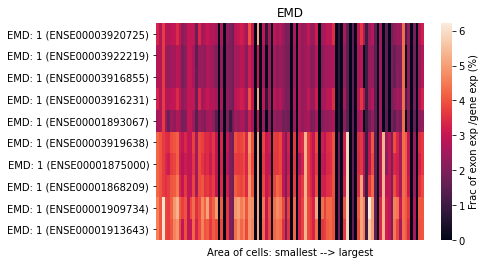

In [75]:
gene = 'EMD'
n = 10
exons = corr_all[corr_all['gene_name'] == gene].nsmallest(n, 'area')['gene_n_id']
cols = adata.obs['area'].sort_values().index
df =  exon_fra_df.set_index('gene_n_id').loc[exons][cols] * 100
df.columns = [col.split('_')[1] for col in df.columns]

fig, ax = plt.subplots()
sns.heatmap(df, ax=ax, cbar_kws={'label':'Frac of exon exp /gene exp (%)'},)
ax.set_ylabel(None)
ax.set_xlabel('Area of cells: smallest → largest')
ax.set_title(gene)
ax.set_xticks([])
ax.set_xticklabels([])

fig.savefig(save_figures + f'{gene}_{n}.png', bbox_inches='tight', dpi=300)

## plot the example of alternative splicing

In [8]:
corr_all = pd.read_csv(save_figures + 'area_exon_fra_all.tsv', sep='\t', index_col=['gene_name', 'exon_number'])

In [10]:
exon_fra_df.index

MultiIndex([(   'AUH', 10),
            (  'CHN1', 13),
            ( 'COX15',  1),
            ( 'DHCR7',  9),
            (  'FLNB',  1),
            ('IFNGR1',  1),
            ( 'MYH10',  1),
            ('NFKBIA',  1),
            ( 'RPS29',  1),
            ('SLC7A2', 13),
            ...
            ( 'SNX14', 11),
            ( 'UBAP2',  9),
            (   'MR1',  1),
            (   'FAH',  1),
            ('FBXO11', 22),
            (  'FLNB', 17),
            ( 'CERT1', 16),
            ( 'RAB18',  2),
            ( 'PPARG',  7),
            ( 'GLUD1',  4)],
           names=['gene_name', 'exon_number'], length=196408)

In [11]:
# culculate exon usgae by exon number
# total fraction of exon ids sharing the same exon number
exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)
exon_fra_df.index.name = 'exon_id'
# add exon number and gene name
exon_fra_df['gene_name'] = corr_all.reset_index().set_index('id').loc[exon_fra_df.index]['gene_name']
exon_fra_df['exon_number'] = corr_all.reset_index().set_index('id').loc[exon_fra_df.index]['exon_number']
# set index as the same as correlations
exon_fra_df = exon_fra_df.set_index(['gene_name', 'exon_number'])

# create a new dataframe to store data
idx = np.unique(exon_fra_df.index)
number_fra = pd.DataFrame(columns=exon_fra_df.columns, index=idx)
number_fra['gene_name'] = [i[0] for i in idx]
number_fra['exon_number'] = [i[1] for i in idx]
number_fra = number_fra.set_index(['gene_name', 'exon_number'])

# culculateing
for i in number_fra.index:
        number_fra.loc[i] = exon_fra_df.loc[i].sum(axis=0).loc[number_fra.columns]
        
# save data
number_fra.to_csv(save_figures + 'exon_number_fraction.tsv', sep='\t')

In [13]:
for i in number_fra.index:
        number_fra.loc[i] = exon_fra_df.loc[i].sum(axis=0).loc[number_fra.columns]
        
# save data
number_fra.to_csv(save_figures + 'exon_number_fraction.tsv', sep='\t')

<ipython-input-13-36bf42345e00>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  number_fra.loc[i] = exon_fra_df.loc[i].sum(axis=0).loc[number_fra.columns]


In [ ]:
if True:
    # exon number and area correlations
    print('Correlate with some simple features')
    feas = ['area']

    phe = adata.obs[feas].fillna(0)
    x = number_fra[phe.index].values
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
        yw = np.zeros(y.shape, float)
        
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                        data=r,
                        index=number_fra.index,
                        columns=phe.columns,
                        dtype=float)
    corr.to_csv(save_figures + 'area_exon_number_fra.tsv', sep='\t')

In [ ]:
number_fra = pd.read_csv(save_figures + 'exon_number_fraction.tsv', sep='\t', index_col=['gene_name', 'exon_number'])

In [158]:
ls = corr.sort_values('area')[-50:].reset_index()['gene_name']
for i in ls:
    print('---------------------{}-------------------'.format(i))
    print(corr.loc[i]['area'])

---------------------GALNS-------------------
exon_number
1     0.168892
2     0.190910
3     0.223537
4     0.192344
5     0.350735
6     0.263234
7     0.268119
8     0.280427
9     0.261541
10    0.195896
11    0.243044
12    0.370380
13    0.232129
14    0.380789
15    0.335990
Name: area, dtype: float64
---------------------CHD4-------------------
exon_number
1     0.190005
2     0.077823
3     0.114767
4     0.102135
5     0.144497
6     0.265046
7     0.247974
8     0.116058
9     0.016386
10    0.061208
11    0.114123
12    0.102061
13    0.184962
14    0.132495
15    0.185558
16    0.174658
17    0.098232
18    0.065259
19    0.059040
20    0.070354
21   -0.088542
22    0.002461
23    0.264733
24    0.234514
25    0.271113
26    0.267199
27    0.287513
28    0.381015
29    0.298492
30    0.291119
31    0.277198
32    0.225878
33    0.306321
34    0.227292
35    0.118443
36    0.157910
37    0.251408
38    0.275150
39    0.281670
40    0.205641
41    0.204880
Name: area, dtype:

In [14]:
def plot_bin_exons(number_fra, gene, exon_ns, bin_n, cmaps, filetype, path=False):
    # create dataframe
    area_order = adata.obs['area'].sort_values().index
    df = number_fra.loc[gene].loc[exon_ns].T.loc[area_order] * 100
    df['order'] = '0'
    for i in range(bin_n):
        n = round(df.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < df.shape[0]]
        df.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    # plot boxplots
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    fig, axs = plt.subplots(1, len(exon_ns), figsize=[0.5 + 2 * len(exon_ns), 3], sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.05)
    
    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
        
    name = gene
    for i, (n, cmap) in enumerate(zip(exon_ns, cmaps)):

        med = [df[df['order'] == 'Group {}'.format(str(i + 1))][n].median()
           for i in range(bin_n)]
        alpha = [0.2 + 0.6 * i/max(med) for i in med]
        cmap = mpl.cm.get_cmap(cmap)
        palette = [cmap(i) for i in alpha]

        sns.boxplot(data=df, x='order', y=n, palette=palette, ax=axs[i], **PROPS)
        sns.stripplot(data=df, x='order', y=n, palette=palette, edgecolor='white', linewidth=1, ax=axs[i], size=3)
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel(None)
        axs[i].set_ylabel(None)
        axs[i].set_title('{}: exon {}'.format(gene, str(n)))
        
        name += str(n)
        
    fig.text(0.5, 0.05, '{} of cells: smallest → largest'.format(fea.title()), va='center', ha='center')
    fig.text(0.05, 0.5, 'Frac of exon exp/gene exp [%]', va='center', ha='center', rotation=90)

    if path is not False:
        fig.savefig(os.path.join(path, name+filetype), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'axs': axs}

{'fig': <Figure size 468x216 with 3 Axes>,
 'axs': array([<AxesSubplot: title={'center': 'CS: exon 1'}>,
        <AxesSubplot: title={'center': 'CS: exon 4'}>,
        <AxesSubplot: title={'center': 'CS: exon 11'}>], dtype=object)}

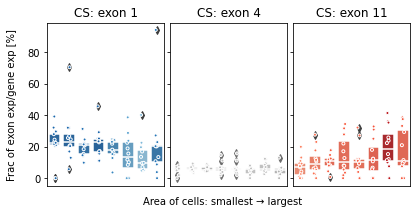

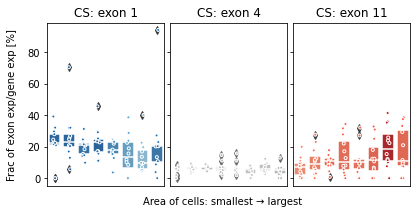

In [15]:
fea = 'area'
gene = 'CS'
exon_ns = [1, 4, 11]
bin_n = 8
cmaps = ['Blues', 'gray', 'Reds']
path = save_figures

plot_bin_exons(number_fra, gene, exon_ns, bin_n, cmaps, '.png', path)
plot_bin_exons(number_fra, gene, exon_ns, bin_n, cmaps, '.pdf', path)